In [185]:
!pip install tensorflow[and-cuda]
!pip install pandas
!pip install yfinance
!pip install scikit-learn  
!pip install plotly
!pip install imblearn
!pip install seaborn
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


In [1]:
import numpy as np
#%pip install tensorflow
#%pip install protobuf
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
#%pip install numpy
import tensorflow as tf
#tf.config.list_physical_devices("GPU")

2024-07-29 06:12:23.398236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 06:12:23.408306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 06:12:23.418584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 06:12:23.421639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 06:12:23.431355: I tensorflow/core/platform/cpu_feature_guar

In [2]:

tf.config.list_physical_devices("GPU")

I0000 00:00:1722247947.956243   12403 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722247947.984788   12403 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722247947.984959   12403 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinancetool as yft
import techinal_indicato as ti
import model_logistic_regression as ml
import plots
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import auc, precision_score, recall_score, roc_curve
import keras

import importlib
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)

# #global constant
Buy = 1
Sell = -1
Neutral = 0

2024-08-05 14:34:06.927765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 14:34:06.938340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 14:34:06.948456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 14:34:06.951488: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 14:34:06.961005: I tensorflow/core/platform/cpu_feature_guar

##Pre-preocessing

In [2]:

importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)

basepath = "../data/"
yfh = yft.YFinanceHelper(basepath)
tih = ti.TechinalIndicatoHelper()
ml_lr =  ml.LogisticRegressionHelper()
ml_gb =  ml.GradientBoostClassifierHelper()
ml_lstm = ml.LongShortTermMemoryMLHelper()
sd = '1887-12-31' #'2014-01-01'
ed = '2023-12-31' #'1999-12-31'#'2023-12-31'

#last 1 year data for testing
test_exit_date = pd.to_datetime(ed)
test_entry_date = test_exit_date - pd.Timedelta(days=365*1)

# all date except last date for training
train_start_date = pd.to_datetime(sd)
train_end_date = test_entry_date
#appl
ticker_symbol = "AAPL" #PFE, AAPL, MSFT, NVDA, AVGO (Broadcom Inc), ORCL


#stock_df = yfh.get_data(ticker_symbol,sd,ed)[['Date', 'Adj Close','Volume']]

stock_df_with_indecators_MSFT = tih.get_dataset(yfh,"MSFT",sd,ed,28)  # .apply_techinal_indicators(stock_df, 28)
stock_df_with_indecators_AAPL = tih.get_dataset(yfh,"AAPL",sd,ed,28)

stock_df_with_indecators_ORCL = tih.get_dataset(yfh,"ORCL",sd,ed,28)  # .apply_techinal_indicators(stock_df, 28)
stock_df_with_indecators_NVDA = tih.get_dataset(yfh,"NVDA",sd,ed,28)

stock_df_with_indecators_PFE = tih.get_dataset(yfh,"PFE",sd,ed,28)

stock_df_with_indecators_MARUTI = tih.get_dataset(yfh,"MARUTI.NS",sd,ed,28)

training_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] >= pd.to_datetime('2023-01-01'))]

training_stock_df_with_indecators_AAPL = stock_df_with_indecators_AAPL[(stock_df_with_indecators_AAPL['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_AAPL = stock_df_with_indecators_AAPL[(stock_df_with_indecators_AAPL['Date'] >= pd.to_datetime('2023-01-01'))]


training_stock_df_with_indecators_ORCL = stock_df_with_indecators_ORCL[(stock_df_with_indecators_ORCL['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_ORCL = stock_df_with_indecators_ORCL[(stock_df_with_indecators_ORCL['Date'] >= pd.to_datetime('2023-01-01'))]


training_stock_df_with_indecators_NVDA = stock_df_with_indecators_NVDA[(stock_df_with_indecators_NVDA['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_NVDA = stock_df_with_indecators_NVDA[(stock_df_with_indecators_NVDA['Date'] >= pd.to_datetime('2023-01-01'))]

training_stock_df_with_indecators_PFE = stock_df_with_indecators_PFE[(stock_df_with_indecators_PFE['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_PFE = stock_df_with_indecators_PFE[(stock_df_with_indecators_PFE['Date'] >= pd.to_datetime('2023-01-01'))]

training_stock_df_with_indecators_MARUTI = stock_df_with_indecators_MARUTI[(stock_df_with_indecators_MARUTI['Date'] < pd.to_datetime('2023-01-01'))]
testing_stock_df_with_indecators_MARUTI = stock_df_with_indecators_MARUTI[(stock_df_with_indecators_MARUTI['Date'] >= pd.to_datetime('2023-01-01'))]



#features = ['Adj Close','WMA'] #['Adj Close','WMA','VPT','RSI','VPT EMA Signal Line'] #'RSI','VPT','Volume'   ||  ['Adj Close','WMA'] #'RSI','VPT','Volume'     'WMA','VPT','RSI'
#target = "WMA VPT Signal"

#ml_lr.train_logistic_regression_model(testing_stock_df_with_indecators_AAPL,features,target)

#print(stock_df_with_indecators_AAPL['WMA VPT Signal'].value_counts())
#vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_ORCL["Adj Close"],testing_stock_df_with_indecators_ORCL['WMA VPT Signal'])
#print(f"WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

##LSTM

In [3]:
from sklearn.preprocessing import MinMaxScaler
features = ['Adj Close','WMA','VPT','RSI','VPT EMA Signal Line',"WMA VPT Signal"]

scaler1 = MinMaxScaler()
X_train_scaled1 = scaler1.fit_transform(training_stock_df_with_indecators_MSFT[features])


scaler2 = MinMaxScaler()
X_train_scaled2 = scaler2.fit_transform(training_stock_df_with_indecators_ORCL[features])

X_train_scaled = np.concatenate((X_train_scaled1,X_train_scaled2))
#print(X_train_scaled.shape)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=features)
X_train_scaled['WMA VPT Signal'][X_train_scaled['WMA VPT Signal']==0.0] = -1.0
X_train_scaled['WMA VPT Signal'][X_train_scaled['WMA VPT Signal']==0.5] = 0.0 
X_train_scaled['WMA VPT Signal'][X_train_scaled['WMA VPT Signal']==1.0] = 1.0
X_train_scaled['WMA VPT Signal'] 
# print(type(X_train_scaled1))
# print()
# print(X_train_scaled2.min())

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
18440    0.0
18441    0.0
18442    1.0
18443    0.0
18444    0.0
Name: WMA VPT Signal, Length: 18445, dtype: float64

before WMA VPT Signal
 0    7762
 1     831
-1     629
Name: count, dtype: int64
after WMA VPT Signal
 0    7762
 1     831
-1     629
Name: count, dtype: int64
after (7369, 10, 4)
before WMA VPT Signal
 0    7471
 1    1136
-1     616
Name: count, dtype: int64
after WMA VPT Signal
 0    7471
 1    1136
-1     616
Name: count, dtype: int64
after (7370, 10, 4)
before WMA VPT Signal
 0    8911
 1    1060
-1     577
Name: count, dtype: int64
after WMA VPT Signal
 0    8911
 1    1060
-1     577
Name: count, dtype: int64
after (8430, 10, 4)
before WMA VPT Signal
 0    5002
 1     617
-1     352
Name: count, dtype: int64
after WMA VPT Signal
 0    5002
 1     617
-1     352
Name: count, dtype: int64
after (4768, 10, 4)
before WMA VPT Signal
 0    10675
 1     1224
-1      803
Name: count, dtype: int64
after WMA VPT Signal
 0    10675
 1     1224
-1      803
Name: count, dtype: int64
after (10153, 10, 4)
X_train.shape (7369, 10, 4)
y_train.shape (7369, 3)


I0000 00:00:1722540661.755728  192726 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722540661.870923  192726 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722540661.871128  192726 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722540661.880496  192726 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722540661.880749  192726 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Epoch 1/10


2024-08-01 15:31:06.524908: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6042 - loss: 1.2809 - val_accuracy: 0.8258 - val_loss: 0.9315
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8405 - loss: 0.8503 - val_accuracy: 0.8296 - val_loss: 0.7866
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8422 - loss: 0.7527 - val_accuracy: 0.8296 - val_loss: 0.7185
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8469 - loss: 0.6851 - val_accuracy: 0.8296 - val_loss: 0.6649
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8435 - loss: 0.6492 - val_accuracy: 0.8296 - val_loss: 0.6397
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8425 - loss: 0.6293 - val_accuracy: 0.8296 - val_loss: 0.6308
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8423 - loss: 0.6129 - val_accuracy: 0.8296 - val_loss: 0.6066
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8443 - loss: 0.5947 - val_accuracy: 0.8296 - val_loss: 0.5980
Epoch 9/10


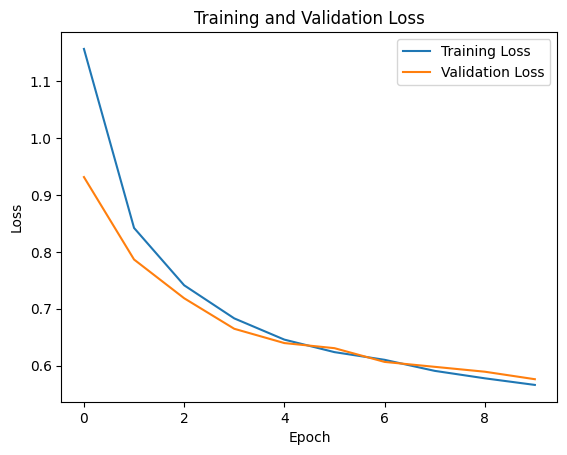

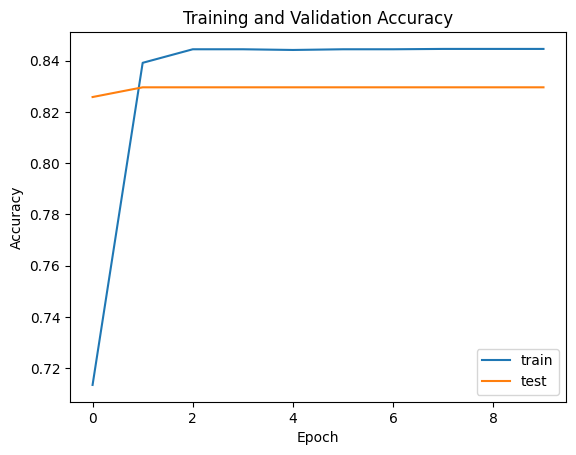

In [3]:
importlib.reload(ml)
from sklearn.preprocessing import StandardScaler,MinMaxScaler
ml_lstm = ml.LongShortTermMemoryMLHelper()
#'adj_close_diff', 'WMA_diff',"VPT_diff","RSI_diff"
features = ['Adj Close','WMA','VPT','RSI'] #['Adj Close','WMA','VPT','RSI','VPT EMA Signal Line'] #'RSI','VPT','Volume'   ||  ['Adj Close','WMA'] #'RSI','VPT','Volume'     'WMA','VPT','RSI'
target = "WMA VPT Signal"
time_step = 10
ml_lstm.dataset1=[]
ml_lstm.add_dataset_under_sample("MSFT",training_stock_df_with_indecators_MSFT,features,target,time_step)
ml_lstm.add_dataset_under_sample("ORCL",training_stock_df_with_indecators_ORCL,features,target,time_step)
ml_lstm.add_dataset_under_sample("AAPL",training_stock_df_with_indecators_AAPL,features,target,time_step)
ml_lstm.add_dataset_under_sample("NVDA",training_stock_df_with_indecators_NVDA,features,target,time_step)
ml_lstm.add_dataset_under_sample("PFE",training_stock_df_with_indecators_PFE,features,target,time_step)
ml_lstm.add_dataset_under_sample("MARUTI",training_stock_df_with_indecators_MARUTI,features,target,time_step)
#print(training_stock_df_with_indecators_MSFT)

#ml_lstm.combine_dataset(
#ml_lstm.add_dataset_under_sample("MSFT",training_stock_df_with_indecators_MSFT,features,target)

# ##############
# ################
# all_db = pd.concat([training_stock_df_with_indecators_MSFT,training_stock_df_with_indecators_ORCL,training_stock_df_with_indecators_AAPL,training_stock_df_with_indecators_NVDA])
# # Feature selection using SelectKBest with chi-squared statistical test
# scaler = MinMaxScaler()
# scaler1 = MinMaxScaler()
# X_undersampled_scaled = scaler.fit_transform(all_db[features])
# #y_undersampled_scaled = scaler1.fit_transform(training_stock_df_with_indecators_MSFT[target])
# print(X_undersampled_scaled)
# selector = SelectKBest(score_func=chi2,k='all')
# X_selected = selector.fit(X_undersampled_scaled, all_db[target])

# # Get the selected feature indices
# selected_feature_indices = selector.get_support(indices=True)

# # Get the names of the selected features
# #selected_feature_names = X.columns[selected_feature_indices]

# # Print the selected feature names
# df_feature = pd.DataFrame()
# df_feature["columns"]=features
# df_feature["scores"]=X_selected.scores_
# df_feature= df_feature.sort_values(by=['scores'],ascending=False)
# plt.figure(figsize=(10,10))
# sns.barplot(y=df_feature["columns"], x=df_feature["scores"])
# plt.title("chi-squared distribution to select the feature")
ml_lstm.train_lstm_model(["MSFT"],features,target,time_step)#"MSFT","NVDA","AAPL","ORCL","AAPL","PFE"



after (6455, 10, 5)
after (6456, 10, 5)
after (7383, 10, 5)
after (4179, 10, 5)
after (8891, 10, 5)
after (3343, 10, 5)
X_train.shape (6455, 10, 5)
y_train.shape (6455, 3)
[2302 2303 2304 ... 4599 4600 4601]
X_undersampled_scaled1 9222
y_undersampled_encoded 9212
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.1708 - loss: 0.0481 - val_accuracy: 0.0000e+00 - val_loss: 1.4017 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1833 - loss: 0.0475 - val_accuracy: 0.0000e+00 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2004 - loss: 0.0470 - val_accuracy: 0.0000e+00 - val_loss: 1.3691 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2150 - loss: 0.0464 - val_accuracy: 0.0000e+00 - val_loss: 1.3528 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2277 - loss: 0.0460 - val_accuracy: 0.0000e+00 - val_loss: 1.

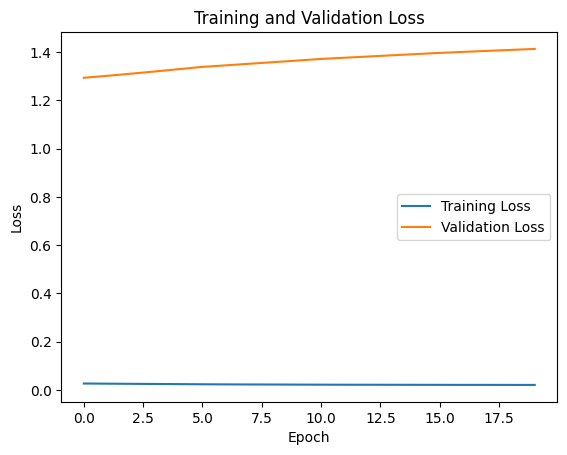

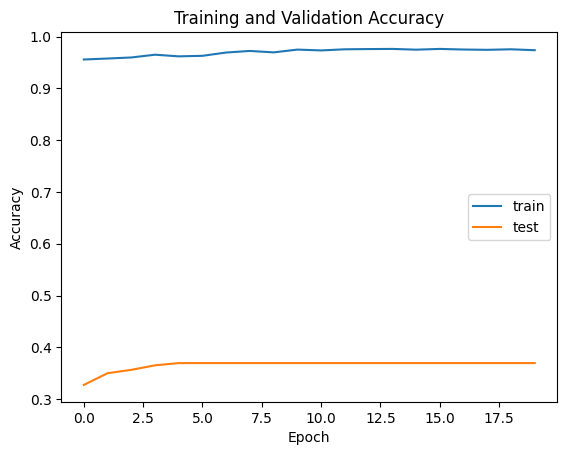

In [21]:
importlib.reload(ml)
from sklearn.preprocessing import StandardScaler,MinMaxScaler
ml_lstm = ml.LongShortTermMemoryMLHelper()
#'adj_close_diff', 'WMA_diff',"VPT_diff","RSI_diff"
features = ['Adj Close','WMA','VPT','RSI','VPT EMA Signal Line'] #['Adj Close','WMA','VPT','RSI','VPT EMA Signal Line'] #'RSI','VPT','Volume'   ||  ['Adj Close','WMA'] #'RSI','VPT','Volume'     'WMA','VPT','RSI'
target = "WMA VPT Signal"
time_step = 10
ml_lstm.dataset1=[]
ml_lstm.add_dataset_under_sample("MSFT",training_stock_df_with_indecators_MSFT,features,target,time_step)
ml_lstm.add_dataset_under_sample("ORCL",training_stock_df_with_indecators_ORCL,features,target,time_step)
ml_lstm.add_dataset_under_sample("AAPL",training_stock_df_with_indecators_AAPL,features,target,time_step)
ml_lstm.add_dataset_under_sample("NVDA",training_stock_df_with_indecators_NVDA,features,target,time_step)
ml_lstm.add_dataset_under_sample("PFE",training_stock_df_with_indecators_PFE,features,target,time_step)
ml_lstm.add_dataset_under_sample("MARUTI",training_stock_df_with_indecators_MARUTI,features,target,time_step)
#print(training_stock_df_with_indecators_MSFT)

#ml_lstm.combine_dataset(
#ml_lstm.add_dataset_under_sample("MSFT",training_stock_df_with_indecators_MSFT,features,target)

# ##############
# ################
# all_db = pd.concat([training_stock_df_with_indecators_MSFT,training_stock_df_with_indecators_ORCL,training_stock_df_with_indecators_AAPL,training_stock_df_with_indecators_NVDA])
# # Feature selection using SelectKBest with chi-squared statistical test
# scaler = MinMaxScaler()
# scaler1 = MinMaxScaler()
# X_undersampled_scaled = scaler.fit_transform(all_db[features])
# #y_undersampled_scaled = scaler1.fit_transform(training_stock_df_with_indecators_MSFT[target])
# print(X_undersampled_scaled)
# selector = SelectKBest(score_func=chi2,k='all')
# X_selected = selector.fit(X_undersampled_scaled, all_db[target])

# # Get the selected feature indices
# selected_feature_indices = selector.get_support(indices=True)

# # Get the names of the selected features
# #selected_feature_names = X.columns[selected_feature_indices]

# # Print the selected feature names
# df_feature = pd.DataFrame()
# df_feature["columns"]=features
# df_feature["scores"]=X_selected.scores_
# df_feature= df_feature.sort_values(by=['scores'],ascending=False)
# plt.figure(figsize=(10,10))
# sns.barplot(y=df_feature["columns"], x=df_feature["scores"])
# plt.title("chi-squared distribution to select the feature")
ml_lstm.train_lstm_model(["MSFT"],features,target,time_step)#"MSFT","NVDA","AAPL","ORCL","AAPL","PFE"



In [22]:
lstm_signal_MSFT = ml_lstm.predict_signals("MSFT",testing_stock_df_with_indecators_MSFT,features)
print("MSFT LSTM signals")
print(lstm_signal_MSFT.value_counts())
print()
print(testing_stock_df_with_indecators_MSFT["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["WMA VPT Signal"])
print(f"MSFT WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"][1:],lstm_signal_MSFT)
print(f"MSFT LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")
#########################################
#####################################
######################################
lstm_signal_ORCL = ml_lstm.predict_signals("ORCL",testing_stock_df_with_indecators_ORCL,features)
print("ORCL LSTM signals")
print(lstm_signal_ORCL.value_counts())
print()
print(testing_stock_df_with_indecators_MSFT["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_ORCL["Adj Close"],testing_stock_df_with_indecators_ORCL["WMA VPT Signal"])
print(f"ORCL WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_ORCL["Adj Close"][1:],lstm_signal_ORCL)
print(f"ORCL LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")



#########################################
#####################################
######################################
lstm_signal_PFE = ml_lstm.predict_signals("PFE",testing_stock_df_with_indecators_PFE,features)
print("PFE LSTM signals")
print(lstm_signal_PFE.value_counts())
print()
print(testing_stock_df_with_indecators_PFE["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_PFE["Adj Close"],testing_stock_df_with_indecators_PFE["WMA VPT Signal"])
print(f"PFE WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_PFE["Adj Close"][1:],lstm_signal_PFE)
print(f"PFE LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")


#########################################
#####################################
######################################
lstm_signal_AAPL = ml_lstm.predict_signals("AAPL",testing_stock_df_with_indecators_AAPL,features)
print("AAPL LSTM signals")
print(lstm_signal_AAPL.value_counts())
print()
print(testing_stock_df_with_indecators_AAPL["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_AAPL["Adj Close"],testing_stock_df_with_indecators_AAPL["WMA VPT Signal"])
print(f"AAPL WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_AAPL["Adj Close"][1:],lstm_signal_AAPL)
print(f"AAPL LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")

#########################################
#####################################
######################################
lstm_signal_NVDA = ml_lstm.predict_signals("NVDA",testing_stock_df_with_indecators_NVDA,features)
print("NVDA LSTM signals")
print(lstm_signal_NVDA.value_counts())
print()
print(testing_stock_df_with_indecators_NVDA["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_NVDA["Adj Close"],testing_stock_df_with_indecators_NVDA["WMA VPT Signal"])
print(f"NVDA WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_NVDA["Adj Close"][1:],lstm_signal_NVDA)
print(f"NVDA LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")


#########################################
#####################################
######################################
lstm_signal_MARUTI = ml_lstm.predict_signals("MARUTI",testing_stock_df_with_indecators_MARUTI,features)
print("MARUTI LSTM signals")
print(lstm_signal_MARUTI.value_counts())
print()
print(testing_stock_df_with_indecators_MARUTI["WMA VPT Signal"].value_counts())

# testing_stock_df_with_indecators["LSTM Signal"] = 0
# testing_stock_df_with_indecators["LSTM Signal"][1:] = lstm_signal
print()
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MARUTI["Adj Close"],testing_stock_df_with_indecators_MARUTI["WMA VPT Signal"])
print(f"MARUTI WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print()
lstm_profit, lstm_portfolio_value, lstm_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MARUTI["Adj Close"][1:],lstm_signal_MARUTI)
print(f"MARUTI LSTM Signal : Final Profit: ${lstm_profit:.2f}, {lstm_profit_percentage.round(2)}%")



# print()
# print(testing_stock_df_with_indecators["WMA VPT Signal"].value_counts())
# print()


# ph = plots.PlotHelper()
# ph.plot_vpt(ticker_symbol,testing_stock_df_with_indecators)
# ph.plot(ticker_symbol,'WMA Signal',testing_stock_df_with_indecators)
# ph.plot(ticker_symbol,'WMA VPT Signal',testing_stock_df_with_indecators)
# ph.plot(ticker_symbol,'LSTM Signal',testing_stock_df_with_indecators)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSFT LSTM signals
-1    249
Name: count, dtype: int64

WMA VPT Signal
 0    215
 1     23
-1     12
Name: count, dtype: int64

MSFT WMA VPT Signal : Final Profit: $3240.48, 32.4%

MSFT LSTM Signal : Final Profit: $0.00, 0.0%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ORCL LSTM signals
-1    249
Name: count, dtype: int64

WMA VPT Signal
 0    215
 1     23
-1     12
Name: count, dtype: int64

ORCL WMA VPT Signal : Final Profit: $1708.78, 17.09%

ORCL LSTM Signal : Final Profit: $0.00, 0.0%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
PFE LSTM signals
 0    187
-1     62
Name: count, dtype: int64

WMA VPT Signal
 0    221
-1     15
 1     14
Name: count, dtype: int64

PFE WMA VPT Signal : Final Profit: $-1729.68, -17.3%

PFE LSTM Signal : Final Profit: $0.00, 0.0%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AAPL LSTM signals
-1    249
Name: count, dtype: int64

WMA VPT Signal
 0    215
 1     20
-1     15
Name: count, dtype: int64

AAPL WMA VPT Signal : Final Profit: $2

In [24]:
print(stock_df_with_indecators['WMA Signal'].value_counts())
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators["Adj Close"],testing_stock_df_with_indecators['WMA Signal'])

print(f"WMA Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print(stock_df_with_indecators['WMA VPT Signal'].value_counts())
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators["Adj Close"],testing_stock_df_with_indecators['WMA VPT Signal'])

print(f"WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

print(lstm_signal.value_counts())
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators["Adj Close"][1:],lstm_signal)

print(f"LSTM WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")
#ph = plots.PlotHelper()
#ph.plot_vpt(ticker_symbol,testing_stock_df_with_indecators)

WMA Signal
-1    5768
 1    3732
Name: count, dtype: int64
WMA Signal : Final Profit: $2061.81, 20.62%
WMA VPT Signal
 0    7999
 1     858
-1     643
Name: count, dtype: int64
WMA VPT Signal : Final Profit: $3240.48, 32.4%
 1    166
-1     83
Name: count, dtype: int64
LSTM WMA VPT Signal : Final Profit: $2313.63, 23.14%


In [ ]:
print(stock_df_with_indecators['VPT Signal'].value_counts())
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators["Adj Close"],testing_stock_df_with_indecators['VPT Signal'])

print(f"VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

ph = plots.PlotHelper()
ph.plot_vpt(ticker_symbol,testing_stock_df_with_indecators)

VPT Signal
 1    5983
-1    3517
Name: count, dtype: int64
VPT Signal : Final Profit: $3516.54, 35.17%


In [ ]:
print(stock_df_with_indecators['WMA VPT Signal'].value_counts())
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators["Adj Close"],testing_stock_df_with_indecators['WMA VPT Signal'])

print(f"VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

ph = plots.PlotHelper()
ph.plot_vpt(ticker_symbol,testing_stock_df_with_indecators)

WMA VPT Signal
 0    7999
 1     858
-1     643
Name: count, dtype: int64
VPT Signal : Final Profit: $3240.48, 32.4%


In [ ]:
new_df.info()
numerical_columns = new_df.select_dtypes(include=['float64', 'int32', 'int64'])
numerical_columns.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 12978 entries, 29 to 13006
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            12978 non-null  datetime64[ns]
 1   Adj Close       12978 non-null  float64       
 2   Volume          12978 non-null  int64         
 3   SMA             12978 non-null  float64       
 4   WMA             12978 non-null  float64       
 5   RSI             12978 non-null  float64       
 6   BUB             12978 non-null  float64       
 7   BLB             12978 non-null  float64       
 8   PC              12978 non-null  object        
 9   VPT             12978 non-null  float64       
 10  VPT_EMA         12978 non-null  float64       
 11  WMA Signal      12978 non-null  int32         
 12  SMA Signal      12978 non-null  int32         
 13  RSI Signal      12978 non-null  int32         
 14  PC Signal       12978 non-null  int32         
 15  BB Sig

,Adj Close,Volume,SMA,WMA,RSI,BUB,BLB,VPT,VPT_EMA,WMA Signal,SMA Signal,RSI Signal,PC Signal,BB Signal,VPT Signal,WMA RSI Signal
count,12978.000000,1.297800e+04,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,1.297800e+04,1.297800e+04,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000,12978.000000
mean,10.449364,1.949892e+07,10.419874,10.429784,52.000773,11.050587,9.789160,1.978230e+07,1.973114e+07,-0.099861,-0.116505,-0.028279,-0.083526,-0.021883,-0.166436,-0.133148
std,11.567461,1.915606e+07,11.546288,11.551632,11.287944,12.293259,10.821091,2.457833e+07,2.447345e+07,0.995040,0.993228,0.274332,0.554042,0.348467,0.986090,0.907102
min,0.089612,0.000000e+00,0.100543,0.099751,17.342847,0.112972,0.083470,-7.402551e+07,-5.876828e+07,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.536583,7.091734e+06,0.527636,0.536541,43.812281,0.564513,0.491998,5.074583e+05,5.550560e+05,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
50%,8.091004,1.390811e+07,8.042546,8.055763,52.122436,8.685349,7.473422,2.012335e+07,1.973747e+07,-1.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
75%,16.475897,2.594555e+07,16.452205,16.449543,60.132650,17.346097,15.097305,3.899913e+07,3.911794e+07,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,55.076656,3.053816e+08,51.020910,51.321618,92.963248,56.118453,46.739354,7.086589e+07,6.319266e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'chi-squared distribution to select the feature')

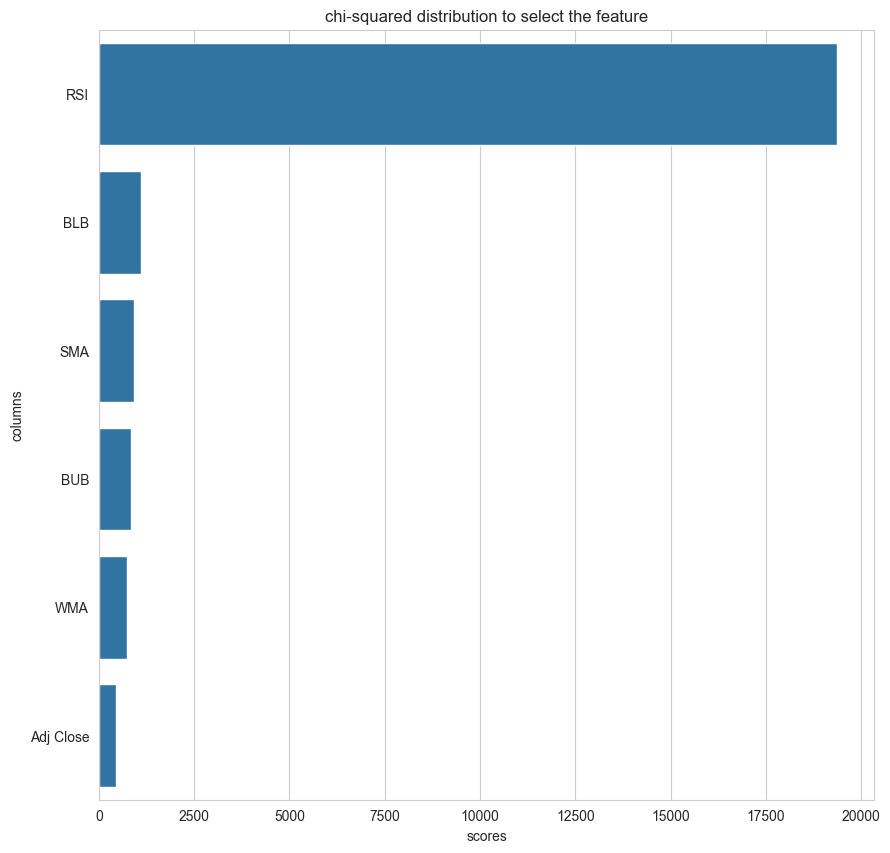

In [ ]:
new_df.describe()
# Selecting numerical columns only for feature selection
numerical_columns = new_df.select_dtypes(include=['float64', 'int32', 'int64'])

# Extracting features and target variable
X = numerical_columns[['Adj Close','SMA',	'WMA',	'RSI',	'BUB'	,'BLB']]#.drop(columns=['WMA Signal'])
# Exclude the target column
y = new_df['PC Signal']  # Target column

# Feature selection using SelectKBest with chi-squared statistical test
selector = SelectKBest(score_func=chi2,k='all')
X_selected = selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print the selected feature names
df_feature = pd.DataFrame()
df_feature["columns"]=X.columns
df_feature["scores"]=X_selected.scores_
df_feature= df_feature.sort_values(by=['scores'],ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=df_feature["columns"], x=df_feature["scores"])
plt.title("chi-squared distribution to select the feature")


In [ ]:
features = ['Adj Close','WMA','VPT','RSI'] #'RSI','VPT','Volume'   ||  ['Adj Close','WMA'] #'RSI','VPT','Volume'     'WMA','VPT','RSI'
target = "WMA Signal"

In [ ]:

#train on previous year
df_train = new_df[(new_df['Date'] >= train_start_date) & (new_df['Date'] <= train_end_date)]
model_lr,scaler_lr = ml_lr.train_logistic_regression_model(df_train,features,target)

ValueError: Input X must be non-negative.

In [ ]:
model_gbr,scaler_gbr = ml_gb.train_gradient_classifier_model(df_train,features,"WMA Signal")


Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 1000}
Mean Squared Error after tuning: 0.20843152657763814


4 (28, 4)
(12700, 28, 4)
(12700, 3)
(8890, 28, 4)
(3810, 28, 4)
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.4900 - loss: 1.0352 - val_accuracy: 0.6005 - val_loss: 0.8429
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6225 - loss: 0.7769 - val_accuracy: 0.6388 - val_loss: 0.6513
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6472 - loss: 0.6385 - val_accuracy: 0.6659 - val_loss: 0.6155
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6735 - loss: 0.6106 - val_accuracy: 0.6916 - val_loss: 0.5850
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7073 - loss: 0.5747 - val_accuracy: 0.7131 - val_loss: 0.5564
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7197 - loss: 0.5536 - val_accuracy: 0.7333 - val_loss: 0.5307
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7344 - loss: 0.5351 - val_accuracy: 0.7449 - val_loss: 0.5159
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - a

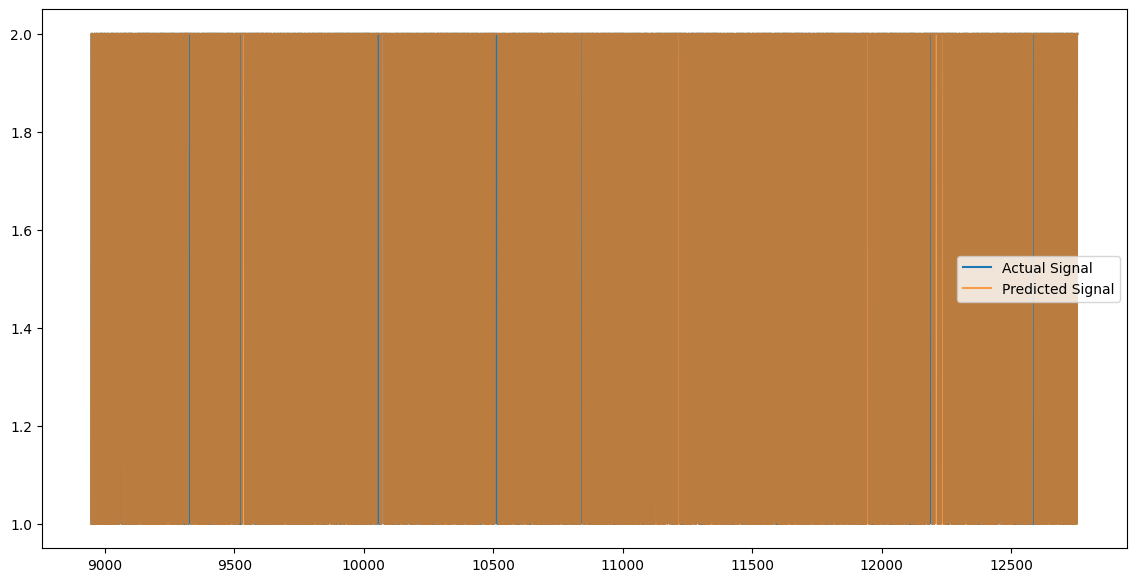

In [ ]:
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)
ml_lstm = ml.LongShortTermMemoryMLHelper()
model_lstm,scaler_lstm = ml_lstm.train_lstm_model(df_train,features,"WMA Signal") 

In [ ]:
def predict_signals(model,scaler,df,features):

    df_features = df[features]
    X_test_scaled = scaler.transform(df_features)
    y_pred = model.predict(X_test_scaled)
    return y_pred

In [ ]:
df_test["LSTM Signal"] =  predict_signals(model_lstm,scaler_lstm,df_test,features)

In [ ]:

#calculate_all_profit(ticker_symbol,df_filter)
df_test["Logistic Signal"] =  predict_signals(model_lr,scaler_lr,df_test,features)
df_test["Gradient WMA RSI Signal"] =  predict_signals(model_gbr,scaler_gbr,df_test,features)

In [ ]:

ml_wam_profit, ml_wam_portfolio_value, ml_wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["Logistic Signal"])
print(f"Logistic Signal : Final Profit: ${ml_wam_profit:.2f}, {ml_wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"Logistic Signal",df_test)

ml_wam_profit, ml_wam_portfolio_value, ml_wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["Gradient WMA RSI Signal"])
print(f"Gradient WMA RSI Signal : Final Profit: ${ml_wam_profit:.2f}, {ml_wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"Gradient WMA RSI Signal",df_test)

# wam_rsi_op_profit, wam_rsi_op_portfolio_value, wam_rsi_op_profit_percentage = calculate_profit(df_test["Adj Close"],df_test["WMA RSI Signal Optimized"])
# print(f"WMA RSI Signal Optimized: Final Profit: ${wam_rsi_op_profit:.2f}, {wam_rsi_op_profit_percentage.round(2)}%")
# plot(ticker_symbol,"WMA RSI Signal Optimized",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["SMA Signal"])
print(f"SMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"SMA Signal",df_test)


wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["WMA RSI Signal"])
print(f"WMA RSI Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"WMA RSI Signal",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["WMA Signal"])
print(f"WMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"WMA Signal",df_test)

wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["RSI Signal"])
print(f"RSI Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
plot(ticker_symbol,"RSI Signal",df_test)

vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(df_test["Adj Close"],df_test["VPT Signal"])
print(f"VPT Signal : Final Profit: ${wam_profit:.2f}, {vpt_profit_percentage.round(2)}%")
plot(ticker_symbol,"VPT Signal",df_test)


# wam_profit, wam_portfolio_value, wam_profit_percentage = calculate_profit(df_test["Adj Close"],df_test["PC Signal"])
# print(f"PC Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")
# plot(ticker_symbol,"PC Signal",df_test)

# Fitting 5 folds for each of 972 candidates, totalling 4860 fits
# Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
# Mean Squared Error after tuning: 0.13197240762326762
# Gradient WMA RSI Signal : Final Profit: $0.00, 0.0%

# Fitting 5 folds for each of 27 candidates, totalling 135 fits
# Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}
# Mean Squared Error after tuning: 0.14824202771314335
# Gradient WMA RSI Signal : Final Profit: $0.00, 0.0%

Logistic Signal : Final Profit: $1204.73, 12.05%


Gradient WMA RSI Signal : Final Profit: $1570.46, 15.7%


KeyError: 'SMA Signal'

In [ ]:
# Specify entry and exit dates
def calculate_all_profit(ticker,df):
    pc_profit, pc_portfolio_value, pc_profit_percentage  = tih.calculate_profit(df["Adj Close"],df["PC Signal"])
    print(f"PC Signal : Final Profit: ${pc_profit:.2f}, {pc_profit_percentage.round(2)}%")
    
    wam_profit, wam_portfolio_value, wam_profit_percentage = tih.calculate_profit(df["Adj Close"],df["WMA Signal"])
    print(f"WMA Signal : Final Profit: ${wam_profit:.2f}, {wam_profit_percentage.round(2)}%")

    rsi_profit, rsi_portfolio_value, rsi_profit_percentage = tih.calculate_profit(df["Adj Close"],df["RSI Signal"])
    print(f"RSI Signal : Final Profit: ${rsi_profit:.2f}, {rsi_profit_percentage.round(2)}%")

    bb_profit, bb_portfolio_value, bb_profit_percentage = tih.calculate_profit(df["Adj Close"],df["BB Signal"])
    print(f"BB Signal : Final Profit: ${bb_profit:.2f}, {bb_profit_percentage.round(2)}%")

    plot(ticker,"PC Signal",df)
    plot(ticker,"WMA Signal",df)
    plot(ticker,"RSI Signal",df)
    plot(ticker,"BB Signal",df)
    